<h1>Feature Selection Voluntarios Treatment</h1>

<h2>Monica Ruiz Rosario</h2>


<H4> Features selection of human samples grouped by volunteer number

In [1]:
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import urllib.request as urllib
import sys

<H4>Loading the data from the CSV files</H4>

In [70]:
data_hum = pd.read_csv('DifferentialGenesFoldChageByVolunteer1.csv', sep=';')
lista = [ 0, 0 , 0, 1, 1, 0, 0, 1 ]
data_hum['Lable'] = pd.Series(lista, index=data_hum.index)
X = data_hum.values[ 0:, 1:-1].astype(np.float)
y = (data_hum.values[ 0:, -1 ] == 0).astype(np.int)
features = np.array(list(data_hum)[:-1])
data_hum.shape

(8, 807)

In [7]:
(data_hum.values[ 0:, -1 ] == 0).astype(np.int)

array([1, 1, 1, 0, 0, 1, 1, 0])

In [6]:
data_hum

,GeneId,ENSG00000250565,ENSG00000184702,ENSG00000163464,ENSG00000175556,ENSG00000197771,ENSG00000034693,ENSG00000135919,ENSG00000083635,ENSG00000249087,...,ENSG00000198056,ENSG00000182580,ENSG00000089220,ENSG00000268861,ENSG00000130940,ENSG00000114023,ENSG00000128739,ENSG00000099364,ENSG00000153885,Lable
0,Vol22,0.037334,1.764498,-0.466725,0.199044,-0.538142,0.178594,-0.433383,-0.144659,0.336135,...,0.046372,1.018643,-0.136003,-0.670971,0.144258,0.474156,0.131337,0.292820,0.121945,0
1,Vol21,-0.355682,0.460340,0.259717,0.219379,-0.314100,-0.193641,0.261503,0.021603,-0.586878,...,0.044727,1.041699,-0.280669,-0.241121,0.099434,0.309017,0.140579,0.205185,0.077161,0
2,Vol20,-0.123347,0.833561,-0.141047,0.035530,-0.447935,-0.112696,-0.168273,-0.448357,-0.006353,...,0.093353,2.267085,-0.240777,0.230487,0.967090,0.659526,-0.165646,0.705663,0.426226,0
3,Vol19,4.279154,0.786694,0.754017,2.336969,-0.663220,4.244540,-5.056953,4.734770,4.597898,...,4.037009,-2.684412,-0.761704,16.436110,4.991261,1.837799,-0.139316,4.933442,-0.065647,1
4,Vol16,1.749709,0.212005,0.447021,1.765351,0.371227,-1.669864,0.009994,-3.855000,-2.393126,...,2.891147,4.342871,-1.362929,-0.118389,0.260513,5.621881,-0.431263,0.429772,-0.244512,1
5,Vol15,-0.727112,1.627937,0.290856,0.027966,-0.375603,-0.747936,0.179503,0.135940,-0.016995,...,-0.312071,2.199381,-0.042038,0.169723,0.448860,0.181668,0.239301,0.155608,-0.116274,0
6,Vol13,-0.318805,1.384092,0.572114,0.315739,0.127633,-0.163911,-0.192469,0.084964,0.622811,...,-0.005404,2.223937,-0.056434,0.070000,-0.119804,0.706161,0.028982,0.241600,-0.193759,0
7,Vol11,-0.160961,0.844908,1.273998,-0.854120,-0.135651,-0.508931,-5.317703,-0.596327,1.255474,...,-0.132780,1.673298,-0.394335,-0.424241,0.699718,0.325061,0.207466,2.128387,-0.300507,1


<h4>Function that performs the data standarization</h4>

In [8]:
def data_standarization(X, y, train_index, test_index):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #Data standarization
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return [X_train_scaled , y_train, X_test_scaled, y_test]

<h4>Function that evaluates the performance for each Value of the Hyperparameters, and chooses the best hyperparameter (Number of neighbors)</h4>

In [42]:
def Hyperparameters_evaluation(pipeline, X_train_scaled, y_train):
    #Specification of the Hyperparameters (number of neighbors to consider)
    N_neighbors = [1, 2]
    param_grid = { 'knn__n_neighbors': N_neighbors }
    
    #Evaluating the Performance for each Value of the Hyperparameters
    skfold = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=None)
    gridcv = GridSearchCV(pipeline, cv=skfold, n_jobs=1, param_grid=param_grid, \
    scoring= make_scorer(accuracy_score))
    result = gridcv.fit(X_train_scaled, y_train)
    
    #Obtain the mean accuracy and the corresponding standard deviation across data splits.
    accuracies = gridcv.cv_results_['mean_test_score']
    std_accuracies = gridcv.cv_results_['std_test_score']
    
    #Choose the best hyperparameter
    best_reg_param_value = param_grid['knn__n_neighbors'][ np.argmax(accuracies) ]
    
    return(best_reg_param_value)

<h4>Function that estimates the performance of the Model</h4>

In [32]:
def Model_performance(best_reg_param_value, X_train_scaled , y_train, X_test_scaled, y_test):
    #Computation of the confusion matrix on the test set
    knn = KNeighborsClassifier(n_neighbors = best_reg_param_value)
    knn.fit(X_train_scaled, y_train)
    
    accuracy= np.mean(knn.predict(X_test_scaled) == y_test)
    
    return accuracy

<h4>Function that performs the F-score feature selection</h4>

In [33]:
def Filtering_Fscore(k_features, X_train , y_train, X_test, y_test):
    
    filtering = SelectKBest(f_classif, k_features)
    
    filtering.fit(X_train, y_train)
    X_train_vr = filtering.transform(X_train)
    X_test_vr = filtering.transform(X_test)
    
    return[X_train_vr , y_train, X_test_vr, y_test]

<H4>Function that performs Random Forest feature selection</H4>

In [34]:
def Filtering_RandomForest(k_features_rf, X_train_vr , y_train, X_test_vr, y_test):
    
    rf_selection = SelectFromModel(RandomForestClassifier(n_estimators = 2000, \
    random_state = 0), threshold = 0.0)
    
    rf_selection.fit(X_train_vr, y_train)
    rf_selection.threshold = -1.0 * np.sort(-1.0 * rf_selection.estimator_.feature_importances_)[ k_features_rf - 1 ]
    X_train_rf = rf_selection.transform(X_train_vr)
    X_test_rf = rf_selection.transform(X_test_vr)
    
    return[X_train_rf , y_train, X_test_rf, y_test]

<h4>1. Estimate the performance of the nearest neighbor classifier on this dataset using 10-fold cross validation when all the features are used for prediction. The number of neighbors should be chosen using an inner cross-validation procedure. You can use 5-fold cross validation for this.</h4>

In [44]:
#10-fold cross validation
n_repeats = 10
rkfNNC_1 = RepeatedKFold(n_splits=3, n_repeats = n_repeats, random_state=None)

total_error_NNC_1=np.zeros(3 * n_repeats)
split = 0

for train_index, test_index in rkfNNC_1.split(X, y):

    sys.stdout.write('.')
    sys.stdout.flush()
        
    dataNNC_1 = data_standarization(X, y, train_index, test_index)
    
    #Defining the Pipeline of Data Transformation and Estimation
    pipelineNNC_1 = Pipeline([ ('knn', KNeighborsClassifier()) ])
    
    #Evaluating the Performance for each Value of the Hyperparameters
    Best_Hyper_NNC_1 = Hyperparameters_evaluation(pipelineNNC_1, dataNNC_1[0],dataNNC_1[1])
    
    #Fitting the Final Model and Estimating Its Performance
    total_error_NNC_1[split]=(1-(Model_performance(Best_Hyper_NNC_1, dataNNC_1[0],dataNNC_1[1], dataNNC_1[2], dataNNC_1[3])))  

    split += 1
    
average_error_NNC_1 = np.mean(total_error_NNC_1)

print('\n',average_error_NNC_1)   

............

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parame

...........

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parame

.......
 0.40000000000000013


C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parame

<h4>2. Estimate the performance of the nearest neighbor classifier on the same dataset when using a feature selection technique based on the F-score (ANOVA) that picks up the 10 most relevant features. Use the same cross-validation methods as in the previous step.</h4>

In [45]:
#10-fold cross validation
n_repeats = 10
rkfNNC_2 = RepeatedKFold(n_splits=3, n_repeats = n_repeats, random_state=None)

total_error_NNC_2=np.zeros(3 * n_repeats)
split = 0

for train_index, test_index in rkfNNC_2.split(X, y):

    sys.stdout.write('.')
    sys.stdout.flush()
        
    dataNNC_2 = data_standarization(X, y, train_index, test_index)
    
    #Defining the Pipeline of Data Transformation and Estimation
    pipelineNNC_2 = Pipeline([ ('knn', KNeighborsClassifier()) ])
    
    #Filtering to pick the 10 most relevant features with the F-score technique
    k_featuresNNC_2 = 10
    dataNNC_2_vr = Filtering_Fscore(k_featuresNNC_2, dataNNC_2[0],dataNNC_2[1], dataNNC_2[2], dataNNC_2[3])
    
    #Evaluating the Performance for each Value of the Hyperparameters
    Best_Hyper_NNC_2 = Hyperparameters_evaluation(pipelineNNC_2, dataNNC_2_vr[0],dataNNC_2_vr[1])
    
    #Fitting the Final Model and Estimating Its Performance
    total_error_NNC_2[split]=(1-(Model_performance(Best_Hyper_NNC_2, dataNNC_2_vr[0],dataNNC_2_vr[1], 
                                                      dataNNC_2_vr[2], dataNNC_2_vr[3])))  

    split += 1
    
average_error_NNC_2 = np.mean(total_error_NNC_2)

print('\n',average_error_NNC_2)

.............

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 m

..........

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 m

.......
 0.37222222222222234


C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few

<h4>3. Repeat the previous experiment but when a random forest is used to pick up the 10 most relevant features. Use an initial filtering method based on the F-score to keep only the 20% most promising features.</h4>

In [46]:
#10-fold cross validation
n_repeats = 10
rkfNNC_3 = RepeatedKFold(n_splits=3, n_repeats = n_repeats, random_state=None)

total_error_NNC_3=np.zeros(3 * n_repeats)
split = 0

for train_index, test_index in rkfNNC_3.split(X, y):

    sys.stdout.write('.')
    sys.stdout.flush()
        
    dataNNC_3 = data_standarization(X, y, train_index, test_index)
    
    #Defining the Pipeline of Data Transformation and Estimation
    pipelineNNC_3 = Pipeline([ ('knn', KNeighborsClassifier()) ])
    
    #Filtering to pick the 20% most relevant features with the F-score technique
    k_featuresNNC_3 = int(np.round(X.shape[ 1 ] * 0.2))
    dataNNC_3_vr = Filtering_Fscore(k_featuresNNC_3, dataNNC_3[0],dataNNC_3[1], dataNNC_3[2], dataNNC_3[3])
    
    #Filtering to pick the 10 most relevant features with Random Forest
    k_features_rfNNC_3 = 10
    dataNNC_3_rf = Filtering_RandomForest(k_features_rfNNC_3, dataNNC_3_vr[0], dataNNC_3_vr[1], dataNNC_3_vr[2],
                                          dataNNC_3_vr[3])
    
    #Evaluating the Performance for each Value of the Hyperparameters
    Best_Hyper_NNC_3 = Hyperparameters_evaluation(pipelineNNC_3, dataNNC_3_rf[0], dataNNC_3_rf[1])
    
    #Fitting the Final Model and Estimating Its Performance
    total_error_NNC_3[split]=(1-(Model_performance(Best_Hyper_NNC_3, dataNNC_3_rf[0],dataNNC_3_rf[1], 
                                                      dataNNC_3_rf[2], dataNNC_3_rf[3])))  

    split += 1
    
average_error_NNC_3 = np.mean(total_error_NNC_3)

print('\n',average_error_NNC_3)

..

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


.

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


.

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


.

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


.

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


..

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


.

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


.

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


.

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


.

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


.

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


.

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


.

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


.

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


.

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


.

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


..

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


.

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


.

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


.

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


.

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


.

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


.

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


.

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


..

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


.

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 0.3444444444444445


C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


In [47]:
Best_Hyper_NNC_3

1

<H3>SUMMARY</H3>

In [48]:
print('Prediction errors calculated:\n')

summary = [ (average_error_NNC_1) ,
            (average_error_NNC_2),
            (average_error_NNC_3)]
 
final = pd.DataFrame(summary, columns = ['Error'], index=['All features', 'Top 10 features (F-score)',
                                                          'Top 10 features (F-score + Random Forest)'])

print(final)

Prediction errors calculated:

                                              Error
All features                               0.400000
Top 10 features (F-score)                  0.372222
Top 10 features (F-score + Random Forest)  0.344444


<h4>4. What feature selection method performs best? Can you explain why?</h4>

The feature selection with F-score + Random Forest performed the best in terms of the generalisation error obtained, however, although the F-score alone obtained a higher error, the difference was small, and this method ran significantly faster. For which when accuracy is the most important, F-score + Random Forest would be the best method, and when time efficiency has a higher weight, F-score alone would be a good choice.

<h4>Now we will address the problem of analyzing the trade-off between interpretability and prediction accuracy. For this, you are asked to:</h4>

<h4>1. Estimate the performance of the nearest neighbor classifier with K=2 as a function of the features used for prediction. Use a 10-times 10-fold cross-validation method and plot the results obtained. That is prediction error vs. the number of features used for prediction. Use the F-score for feature selection. Report results from 1 feature to 200 features. Not all features need to be explored. Use a higher resolution when you are closer to 1 feature.</h4>

In [56]:
ensemble_size = 200

#10-fold cross validation
n_repeats = 10
rkfNNC_4 = RepeatedKFold(n_splits=3, n_repeats = n_repeats, random_state=None)

s = ((3 * n_repeats), ensemble_size)
total_error_NNC_4= np.zeros(s)
split = 0

for train_index, test_index in rkfNNC_4.split(X, y):

    sys.stdout.write('.')
    sys.stdout.flush()
        
    dataNNC_4 = data_standarization(X, y, train_index, test_index)
    
    #Defining the Pipeline of Data Transformation and Estimation
    pipelineNNC_4 = Pipeline([ ('knn', KNeighborsClassifier()) ])
    
    for i in range(ensemble_size):
    
        #Filtering to pick the most relevant features with the F-score technique
        k_featuresNNC_4 = i+1
        dataNNC_4_vr = Filtering_Fscore(k_featuresNNC_4, dataNNC_4[0],dataNNC_4[1], dataNNC_4[2], dataNNC_4[3])

        #Fitting the Final Model and Estimating Its Performance
        total_error_NNC_4[split, i]=(1-(Model_performance(2, dataNNC_4_vr[0],dataNNC_4_vr[1], 
                                                          dataNNC_4_vr[2], dataNNC_4_vr[3])))  
        
    split += 1
    
average_error_NNC_4 = total_error_NNC_4.mean(axis=0)

print('\n',average_error_NNC_4)


..............................
 [0.38888889 0.43333333 0.4        0.4        0.41666667 0.40555556
 0.41666667 0.41666667 0.41666667 0.39444444 0.39444444 0.39444444
 0.39444444 0.39444444 0.39444444 0.39444444 0.38333333 0.38333333
 0.38333333 0.37222222 0.38333333 0.37222222 0.38333333 0.39444444
 0.39444444 0.39444444 0.39444444 0.39444444 0.39444444 0.39444444
 0.39444444 0.39444444 0.39444444 0.39444444 0.39444444 0.36666667
 0.36666667 0.39444444 0.39444444 0.39444444 0.39444444 0.39444444
 0.39444444 0.39444444 0.39444444 0.38333333 0.38333333 0.38333333
 0.38333333 0.38333333 0.38333333 0.38333333 0.38333333 0.38333333
 0.38333333 0.38333333 0.38333333 0.38333333 0.37222222 0.38333333
 0.38333333 0.38333333 0.38333333 0.38333333 0.37222222 0.37222222
 0.37222222 0.38333333 0.38333333 0.38333333 0.38333333 0.38333333
 0.38333333 0.38333333 0.38333333 0.39444444 0.39444444 0.39444444
 0.39444444 0.39444444 0.39444444 0.38333333 0.39444444 0.39444444
 0.38333333 0.38333333 0.38333

<h4>2. Repeat that process when the feature selection is done externally to the cross-validation loop using all the available data. Include these results in the previous plot.</h4>

In [57]:
ensemble_size5 = 200
n_repeats5 = 10
s5 = ((3 * n_repeats5), ensemble_size5)
total_error_NNC_5= np.zeros(s5)

for i in range(ensemble_size5):
    
    sys.stdout.write('.')
    sys.stdout.flush()
    
    #Filtering to pick the most relevant features with the F-score technique
    k_featuresNNC_5 = i+1
    filteringNNC_5 = SelectKBest(f_classif,  k_featuresNNC_5)
    X_fil=filteringNNC_5.fit_transform(X, y)
        
    #10-fold cross validation
    rkfNNC_5 = RepeatedKFold(n_splits=3, n_repeats = n_repeats5, random_state=None)

    split = 0

    for train_index, test_index in rkfNNC_5.split(X_fil, y):

        dataNNC_5 = data_standarization(X_fil, y, train_index, test_index)

        #Defining the Pipeline of Data Transformation and Estimation
        pipelineNNC_5 = Pipeline([ ('knn', KNeighborsClassifier()) ])

        #Fitting the Final Model and Estimating Its Performance
        total_error_NNC_5[split, i]=(1-(Model_performance(3, dataNNC_5[0],dataNNC_5[1], 
                                                              dataNNC_5[2], dataNNC_5[3])))  

        split += 1
    
average_error_NNC_5 = total_error_NNC_5.mean(axis=0)

print('\n',average_error_NNC_5)
       

........................................................................................................................................................................................................
 [0.06666667 0.15555556 0.16666667 0.22222222 0.15555556 0.08888889
 0.15555556 0.23333333 0.2        0.16666667 0.13333333 0.1
 0.18888889 0.21111111 0.11111111 0.21111111 0.11111111 0.11111111
 0.16666667 0.2        0.16666667 0.13333333 0.2        0.08888889
 0.13333333 0.26666667 0.17777778 0.13333333 0.15555556 0.13333333
 0.22222222 0.2        0.11111111 0.23333333 0.22222222 0.23333333
 0.23333333 0.14444444 0.2        0.17777778 0.16666667 0.18888889
 0.15555556 0.13333333 0.17777778 0.2        0.14444444 0.16666667
 0.16666667 0.14444444 0.18888889 0.18888889 0.25555556 0.17777778
 0.14444444 0.15555556 0.2        0.12222222 0.13333333 0.18888889
 0.22222222 0.15555556 0.15555556 0.13333333 0.16666667 0.13333333
 0.18888889 0.24444444 0.18888889 0.1        0.12222222 0.13333333
 

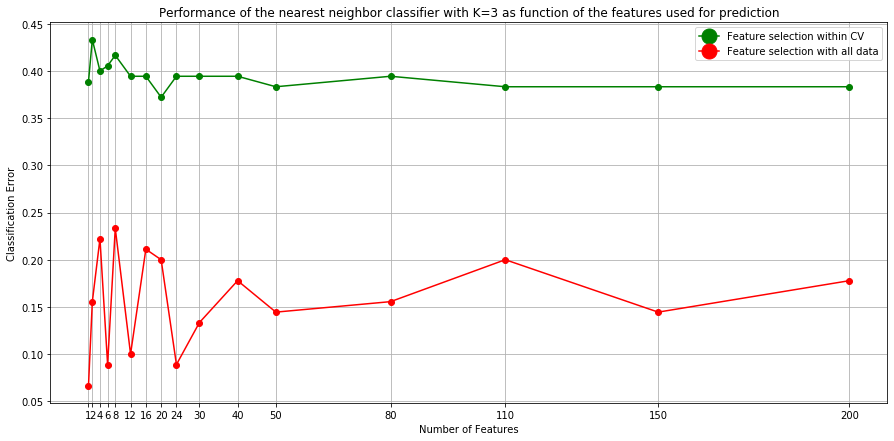

In [58]:
#sel = np.array([0,1,3,5,7,11,15,19,23,29,39,49])
sel = np.array([0,1,3,5,7,11,15,19,23,29,39,49,79,109,149,199])

features = np.arange(1, 500 + 1, 1)

plt.figure(figsize=(15,7))
line1, = plt.plot(features[ sel ], average_error_NNC_4[ sel ], 'o-', color="g")
line1, = plt.plot(features[ sel ], average_error_NNC_5[ sel ], 'o-', color="r")
plt.grid()
plt.title("Performance of the nearest neighbor classifier with K=3 as function of the features used for prediction")
plt.xlabel('Number of Features')
plt.xticks(np.array(features[ sel ]))
plt.ylabel('Classification Error')
legend_handles = [ mlines.Line2D([], [], color='g', marker='o', \
                   markersize=15, label='Feature selection within CV'),
                   mlines.Line2D([], [], color='r', marker='o', \
                   markersize=15, label='Feature selection with all data') ]
plt.legend(handles=legend_handles, loc = 1)
plt.show()

<h4>3. Are the two estimates obtained similar? What are their differences? If they are different try to explain why this is the case.</h4>

Although in general it seems that both approaches follow a similar pattern, increasing and decreasing the classification error for similar number of selected features; the classification error for the case in which all the data was used for the feature selection is much smaller than the error obtained when only the training set is used, this shows that when all the data are used to make selection of attributes, the generalization error is underestimated.

<h4>4. By taking a look at these results, what is the optimal number of features to use in this dataset?</h4>

<h4>5. Given the results obtained in this part of the practical, you are asked to indicate which particular features should be used for prediction on this dataset. Include a list with them. Take a look at the documentation of SelectKBest from scikit-learn to understand how to do this. Use all available data to provide such a list of features. </h4>

In [71]:
#Choise of the optimal number of features according to the min error in the set where feature selection was only performed on
#the training set
best= min(total_error_NNC_4.mean(axis=0))
optimal_number_features = np.where(total_error_NNC_4.mean(axis=0) == min(total_error_NNC_4.mean(axis=0)))
print("Optimal number of features:")
for x in optimal_number_features:
    print(int(x + 1))

Optimal number of features:


TypeError: only size-1 arrays can be converted to Python scalars

In [94]:
optimal_number_features

(array([35, 36], dtype=int64),)

In [72]:
optimal_number_features=20
for x in optimal_number_features: 
    #Filtering of the standarized data for the optimal number of features
    filtering_selec = SelectKBest(f_classif, int(x + 1))
    filtering_selec.fit(dataNNC_4[0],dataNNC_4[1])

    #Use get_support function to obtain the indexes of the selected features and extract them from the features list
    index_features = np.array((filtering_selec.get_support(indices=True)))
    print("\nList of selected features when the optimal number of features is:", int(x+1), "\n")
    print(features[index_features])

TypeError: 'int' object is not iterable

In [95]:
features = np.array(list(data_hum)[:-1])
best = min(total_error_NNC_4.mean(axis=0))

optimal_number_features = np.where(total_error_NNC_4.mean(axis=0) == min(total_error_NNC_4.mean(axis=0)))
x = 20
filtering_selec = SelectKBest(f_classif, int(x + 1))
filtering_selec.fit(dataNNC_4[0],dataNNC_4[1])

#Use get_support function to obtain the indexes of the selected features and extract them from the features list
index_features = np.array((filtering_selec.get_support(indices=True)))
print("\nList of selected features when the optimal number of features is:", int(x+1), "\n")
print(features[index_features])


List of selected features when the optimal number of features is: 21 

['ENSG00000133627' 'ENSG00000162623' 'ENSG00000092330' 'ENSG00000111181'
 'ENSG00000174606' 'ENSG00000139908' 'ENSG00000102384' 'ENSG00000203485'
 'ENSG00000165526' 'ENSG00000156831' 'ENSG00000171219' 'ENSG00000130147'
 'ENSG00000184575' 'ENSG00000100139' 'ENSG00000174574' 'ENSG00000147117'
 'ENSG00000144369' 'ENSG00000036549' 'ENSG00000092758' 'ENSG00000183773'
 'ENSG00000010361']


In [96]:
filtering_selec = SelectKBest(f_classif, int(x + 1))
filtering_selec.fit(dataNNC_3[0],dataNNC_3[1])

#Use get_support function to obtain the indexes of the selected features and extract them from the features list
index_features = np.array((filtering_selec.get_support(indices=True)))
print("\nList of selected features when the optimal number of features is:", int(x+1), "\n")
print(features[index_features])


List of selected features when the optimal number of features is: 21 

['ENSG00000095397' 'ENSG00000130810' 'ENSG00000166707' 'ENSG00000002933'
 'ENSG00000142408' 'ENSG00000069493' 'ENSG00000048462' 'ENSG00000212643'
 'ENSG00000140859' 'ENSG00000127952' 'ENSG00000260170' 'ENSG00000080845'
 'ENSG00000132017' 'ENSG00000196267' 'ENSG00000188033' 'ENSG00000175221'
 'ENSG00000196358' 'ENSG00000163870' 'ENSG00000011052' 'ENSG00000157796'
 'ENSG00000183773']


In [78]:
best

0.36666666666666675

In [79]:
Array1=pd.DataFrame(filtering_selec.fit_transform(dataNNC_4[0],dataNNC_4[1]))

In [80]:
Array3=pd.DataFrame(filtering_selec.fit_transform(dataNNC_4[0],dataNNC_4[1]))

In [81]:
X_fil_fin=filtering_selec.fit_transform(dataNNC_4[0],dataNNC_4[1])

In [84]:
Array2=pd.DataFrame(filtering_selec.fit_transform(dataNNC_4[2],dataNNC_4[3]))

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:110: RuntimeWarning: invalid value encountered in true_divide
  msw = sswn / float(dfwn)


In [85]:
Datafinal=Array1.append(Array2)
Datafinal.to_numpy()
Datafinal.shape

(8, 21)

In [86]:
Datafinal

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-0.539756,0.802310,0.761383,-0.733609,0.694492,0.628485,-0.667453,-0.890535,0.643431,0.697422,...,0.577261,-0.654925,0.721528,-0.645760,-0.614978,-0.676275,-0.661165,0.616380,0.431135,-0.638409
1,-0.612755,0.639169,0.765156,-0.814165,0.804823,0.928065,-0.860813,-0.510834,0.666522,0.839047,...,0.579573,-0.559613,0.843769,-0.827722,-0.586271,-0.633049,-0.639047,0.640975,0.629205,-0.609667
2,1.113187,-1.361401,-1.496825,1.317075,-1.265244,-1.566153,1.089559,1.453035,-1.364591,-1.384378,...,-1.345541,1.710190,-1.407134,1.287748,1.431552,1.491108,1.345872,-1.258226,-1.641446,1.721360
3,1.660571,-1.460628,-1.323345,1.500568,-1.521540,-1.230888,1.683335,1.343161,-1.458144,-1.437620,...,-1.464741,1.058632,-1.381572,1.527617,1.377576,1.329808,1.477118,-1.550618,-1.125233,1.044061
4,-0.916206,0.753330,0.703213,-0.578902,0.393506,0.563797,-0.717718,-0.527362,0.824217,0.647991,...,0.889857,-0.824878,0.866968,-0.724034,-0.942494,-0.693934,-0.731342,0.870926,0.822067,-0.849306
5,-0.705041,0.627220,0.590418,-0.690967,0.893962,0.676694,-0.526910,-0.867465,0.688564,0.637539,...,0.763592,-0.729406,0.356441,-0.617849,-0.665385,-0.817658,-0.791436,0.680564,0.884272,-0.668040
0,-0.674653,0.587798,0.467214,2.417400,0.516458,0.089118,0.285365,0.665915,1.291172,0.058173,...,-0.180849,-0.637436,-0.255817,0.684226,-0.560325,-0.544722,-0.568688,0.841457,-0.476490,0.631883
1,0.439793,0.697285,-0.623710,-31.175918,-1.246655,0.010126,-1.867927,1.485923,-1.352410,-1.248546,...,-0.154760,-0.743330,0.050655,0.134304,-0.520005,-0.230732,-0.647304,1.186052,0.591357,-1.255790


In [87]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.datasets.samples_generator import make_blobs
# sklearn includes kmeans algorithm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.mixture import GaussianMixture as GMM

The center corrdinates for the green cluster are X= 1.386878666389702 Y= -1.4110149561639984
The center corrdinates for the brown cluster are X= -0.6934393331948513 Y= 0.7055074780819992


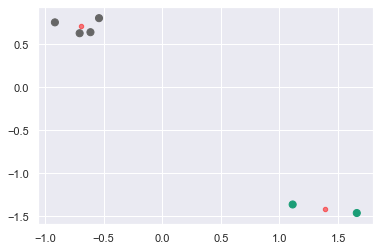

In [88]:
# perform k-means clustering
# 2 clusters are selected as there are 2 labels in our data
kmeans = KMeans(n_clusters=2)

# estimate model parameters with the EM algorithm 
kmeans.fit(X_fil_fin)

# predict the closest cluster each sample in wdbc_data belongs to
y_kmeans = kmeans.predict(X_fil_fin)

# plot the original data and the predicted clusters
plt.scatter(X_fil_fin[:, 0], X_fil_fin[:, 1], c=y_kmeans, s=50, cmap='Dark2')

# plot the cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=20, alpha=0.5);

#print(centers[:, 0], centers[:, 1])
print("The center corrdinates for the green cluster are X=",centers[:, 0][0],"Y=",centers[:, 1][0])
print("The center corrdinates for the brown cluster are X=",centers[:, 0][1],"Y=",centers[:, 1][1])

In [89]:
y_kmeans

array([1, 1, 0, 0, 1, 1])

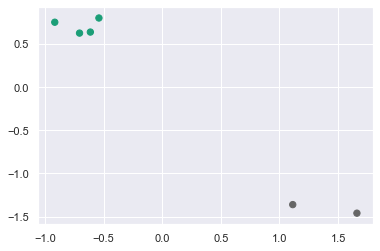

In [90]:
# perform GMM for clustering
# two gaussian functions as we have two original data labels
gmm = GMM(n_components=2).fit(X_fil_fin)

# predict the labels for the data samples in X using trained model
labels = gmm.predict(X_fil_fin)
plt.scatter(X_fil_fin[:, 0], X_fil_fin[:, 1], c=labels, s=40, cmap='Dark2');

In [91]:
labels

array([0, 0, 1, 1, 0, 0], dtype=int64)

In [92]:
dataNNC_4[1]

array([1, 1, 0, 0, 1, 1])

In [93]:
# perform k-means clustering
# 2 clusters are selected as there are 2 labels in our data
kmeans = KMeans(n_clusters=2)

# estimate model parameters with the EM algorithm 
kmeans.fit(Datafinal)

# predict the closest cluster each sample in wdbc_data belongs to
y_kmeans = kmeans.predict(Datafinal)

# plot the original data and the predicted clusters
plt.scatter(Datafinal[:, 0], Datafinal[:, 1], c=y_kmeans, s=50, cmap='Dark2')

# plot the cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=20, alpha=0.5);

#print(centers[:, 0], centers[:, 1])
print("The center corrdinates for the green cluster are X=",centers[:, 0][0],"Y=",centers[:, 1][0])
print("The center corrdinates for the brown cluster are X=",centers[:, 0][1],"Y=",centers[:, 1][1])

TypeError: '(slice(None, None, None), 0)' is an invalid key